In this project, we plan on using real-time api to update stock data for a predetermined set of companies/stocks and compare this data against a user’s inputted stock in order to analyze the most similar stock to the user’s input. The goal of this would be for a user to be able to see companies similar to the ones they already invest in. We plan on using p/e ration, beta and forward dividend yield as criteria points to determine the similarity between different stocks/companies. 


We chose to use the p/e ratio, or price/earnings ratio, because it is important when trying to decide whether to buy a stock or not. This is a ratio of a company’s share price to earnings per share. The main incentive when buying a stock is to make a profit, and the user will want to know what they stand to gain from potentially purchasing this stock. 
We also chose beta, or the numeric value that measures the fluctuations of a stock to changes in the overall stock market, as a point of measurement because we assume that it would be pertinent to the user to know how often a stock fluctuates. Some users may want a more stable stock they plan on owning for a long time while other users might want a more volatile stock that they would like to sell quickly. Knowing an individual stock’s responsiveness in regards to the market as a whole is essential in making this choice, which is why we chose to include it on our model.
Forward dividend and yield in is an estimation of a year’s dividend, or the distribution of a company’s profits to its shareholders, expressed as a percentage of the current stock price. It is generally calculated annually, or over 12 months. Forward dividend yields are very useful when trying to predict future stock prices/revenue because they rely upon past instances. Evidently, this will be useful in our model because it will allow us to calculate what the user could potentially expect in the future in regards to income from a stock based on the price it would be purchased for currently. This would tell the user what they stand to gain from purchasing this stock, and would therefore be very useful in our model. However, this is contingent on the dividend remaining constant, so we would have to account for that.



In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Get a large data set of stocks and their sectors - make a dictionary grouping based on sector

# Read the CSV file into a DataFrame
df = pd.read_csv('/Users/vilaywadhwa/Downloads/sp500_companies.csv')

selected_columns = df[['Sector', 'Symbol', 'Longname', 'Longbusinesssummary']]

grouped_by_sector = selected_columns.groupby('Sector')['Symbol'].apply(list).to_dict()

sector_list = grouped_by_sector.keys()
    

# Step 2: Ask user to pick the sector their stock is in
sector_pick = input("Which of the following sectors does your company fall under?: 'Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities' ")

if sector_pick in sector_list:
    print("You've selected the " + sector_pick + " sector")
    # Step 3: Ask the user to input a stock
    stock_symbol = input("What is the ticker symbol of your company? ").upper()
else: 
    print("Invalid sector selection. Please select a valid sector from the list.")

# Define the URL for Yahoo Finance for the stock
url = f'https://finance.yahoo.com/quote/{stock_symbol}'

# Send a GET request to the URL and retrieve the page content
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find elements that contain the data we want, ps stands for picked stock
    ps_pe_ratio = soup.find('td', {'data-test': 'PE_RATIO-value'})
    ps_beta = soup.find('td', {'data-test': 'BETA_5Y-value'})
    ps_forward_dividend_yield = soup.find('td', {'data-test': 'DIVIDEND_AND_YIELD-value'})

    # Extract the text from the found elements
    ps_pe_ratio_value = ps_pe_ratio.text if ps_pe_ratio else 'N/A'
    ps_beta_value = ps_beta.text if ps_beta else 'N/A'
    ps_dividend_yield_value = ps_forward_dividend_yield.text if  ps_forward_dividend_yield else 'N/A'
    
    if ps_pe_ratio_value != 'N/A':
            ps_pe_ratio_value = float(ps_pe_ratio_value.replace(',', ''))
    else:
            ps_pe_ratio_value = np.nan

    if ps_beta_value != 'N/A':
            ps_beta_value = float(ps_beta_value)
    else:
            ps_beta_value = np.nan

    if ps_dividend_yield_value != 'N/A':
            ps_dividend_yield_value = ps_dividend_yield_value.split(' ')[0]  # Extract dividend value
            ps_dividend_yield_value = float(ps_dividend_yield_value.replace(',', ''))
    else:
            ps_dividend_yield_value = np.nan

    # Print the results
    print(f'Stock Symbol: {stock_symbol}')
    print(f'P/E Ratio: {ps_pe_ratio_value}')
    print(f'Beta: {ps_beta_value}')
    print(f'Forward Dividend & Yield: {ps_dividend_yield_value}')
 
# Initialize an empty list
# Initialize an empty list
data = []

for company in grouped_by_sector[sector_pick]:
    
    url = f'https://finance.yahoo.com/quote/{company}'
    
    # Send a GET request to the URL and retrieve the page content
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find elements that contain the data we want
        pe_ratio = soup.find('td', {'data-test': 'PE_RATIO-value'})
        beta = soup.find('td', {'data-test': 'BETA_5Y-value'})
        forward_dividend_yield = soup.find('td', {'data-test': 'DIVIDEND_AND_YIELD-value'})

        # Extract the text from the found elements
        pe_ratio_value = pe_ratio.text if pe_ratio else 'N/A'
        beta_value = beta.text if beta else 'N/A'
        dividend_yield_value = forward_dividend_yield.text if forward_dividend_yield else 'N/A'

        # Convert values to float (if not 'N/A') and replace 'N/A' with NaN
        if pe_ratio_value != 'N/A':
            pe_ratio_value = float(pe_ratio_value.replace(',', ''))
        else:
            pe_ratio_value = np.nan

        if beta_value != 'N/A':
            beta_value = float(beta_value)
        else:
            beta_value = np.nan

        if dividend_yield_value != 'N/A':
            dividend_yield_value = dividend_yield_value.split(' ')[0]  # Extract dividend value
            dividend_yield_value = float(dividend_yield_value.replace(',', ''))
        else:
            dividend_yield_value = np.nan

        # Append data for the current company to the list
        data.append({
            "Company": company,
            "PE Ratio": pe_ratio_value,
            "Dividend": dividend_yield_value,
            "Beta": beta_value
        })

# Convert the list to a DataFrame
df = pd.DataFrame(data)

def calculate_euclidean_distance(row, user_stock):
    return np.sqrt((row['PE Ratio'] - user_stock['PE Ratio'])**2 +
                   (row['Dividend'] - user_stock['Dividend'])**2 +
                   (row['Beta'] - user_stock['Beta'])**2)

# User's input stock details (example values)
user_stock = {'Company symbol': stock_symbol, 'PE Ratio': ps_pe_ratio_value, 'Dividend': ps_dividend_yield_value, 'Beta': ps_beta_value}

# Exclude the user's company from the DataFrame
df_filtered = df[df['Company'] != user_stock['Company symbol']].copy()

# Calculate the Euclidean distance for each company in the DataFrame
df_filtered['Distance'] = df_filtered.apply(lambda row: calculate_euclidean_distance(row, user_stock), axis=1)
df_sorted = df_filtered.sort_values(by='Distance')

# Find the company with the smallest distance
most_sim_company = df_sorted.iloc[0]
second_most_sim = df_sorted.iloc[1]
third_most_sim = df_sorted.iloc[2]

# Retrieve the full name of the most similar company
most_sim_company_symbol = most_sim_company['Company']
most_sim_company_name = selected_columns.loc[selected_columns['Symbol'] == most_sim_company_symbol, 'Longname'].iloc[0]
most_sim_company_description = selected_columns.loc[selected_columns['Symbol'] == most_sim_company_symbol, 'Longbusinesssummary'].iloc[0]

second_sim_company_symbol = second_most_sim['Company']
second_sim_company_name = selected_columns.loc[selected_columns['Symbol'] == second_sim_company_symbol, 'Longname'].iloc[0]
second_sim_company_description = selected_columns.loc[selected_columns['Symbol'] == second_sim_company_symbol, 'Longbusinesssummary'].iloc[0]

third_sim_company_symbol = third_most_sim['Company']
third_sim_company_name = selected_columns.loc[selected_columns['Symbol'] == third_sim_company_symbol, 'Longname'].iloc[0]
third_sim_company_description = selected_columns.loc[selected_columns['Symbol'] == third_sim_company_symbol, 'Longbusinesssummary'].iloc[0]

# Display the name of the most similar company
print(f"The top 3 most similar companies are:\n"
      f"1: {most_sim_company_name} ({most_sim_company_symbol})\n"
      f"2: {second_sim_company_name} ({second_sim_company_symbol})\n"
      f"3: {third_sim_company_name} ({third_sim_company_symbol})")
      
user_description_response = input("Would you like to see the descriptions of the companies (yes/no): ").strip().lower()

if user_description_response in ['yes', 'y']:
    print("Description of " + most_sim_company_name + " : " + most_sim_company_description)
    print()
    print("Description of " + second_sim_company_name + " : " + second_sim_company_description)
    print()
    print("Description of " + third_sim_company_name + " : " + third_sim_company_description)




Which of the following sectors does your company fall under?: 'Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities' Utilities
You've selected the Utilities sector
What is the ticker symbol of your company? NEE
Stock Symbol: NEE
P/E Ratio: 15.13
Beta: 0.54
Forward Dividend & Yield: 1.87
The top 3 most similar companies are:
1: Dominion Energy, Inc. (D)
2: Evergy, Inc. (EVRG)
3: Sempra (SRE)
Would you like to see the descriptions of the companies (yes/no): yes
Description of Dominion Energy, Inc. : Dominion Energy, Inc. produces and distributes energy. The company operates through four segments: Dominion Energy Virginia, Gas Distribution, Dominion Energy South Carolina, and Contracted Assets. The Dominion Energy Virginia segment generates, transmits, and distributes regulated electricity to residential, commercial, industrial, and governmental customers 

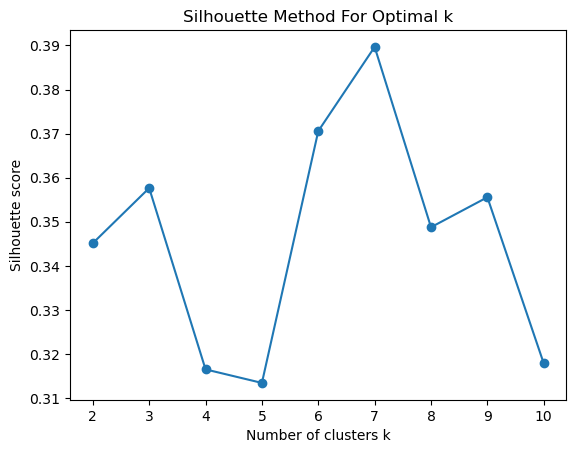

In [2]:
df_numeric = df.dropna(subset=['PE Ratio', 'Dividend', 'Beta']).copy()

sector_longnames = []

for company in df_numeric['Company']:
    longname = selected_columns.loc[selected_columns['Symbol'] == company, 'Longname'].values[0]
    sector_longnames.append(longname)

df_numeric['CompanyName'] = sector_longnames

# Extract the relevant features for clustering
features = df_numeric[['PE Ratio', 'Dividend', 'Beta' ]]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculate silhouette score for different k values
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_scores.append(silhouette_score(features_scaled, cluster_labels))

# Plot Silhouette scores against k
plt.plot(range(2, 11), silhouette_scores, marker='o')  # Adjust range accordingly
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

# Find the index of the highest silhouette score
optimal_k_index = np.argmax(silhouette_scores)

# Find the optimal number of clusters from the silhouette scores
optimal_k = range(2, 11)[optimal_k_index]  # Adjust the range if necessary


         PE Ratio  Dividend   Beta
Cluster                           
0          16.570     3.850  0.660
1          23.480     0.880  0.875
2          17.164     3.492  0.458
3          39.290     1.640  0.470
4          16.525     2.094  0.544
5          18.675     2.665  0.810
6          26.140     2.805  0.590


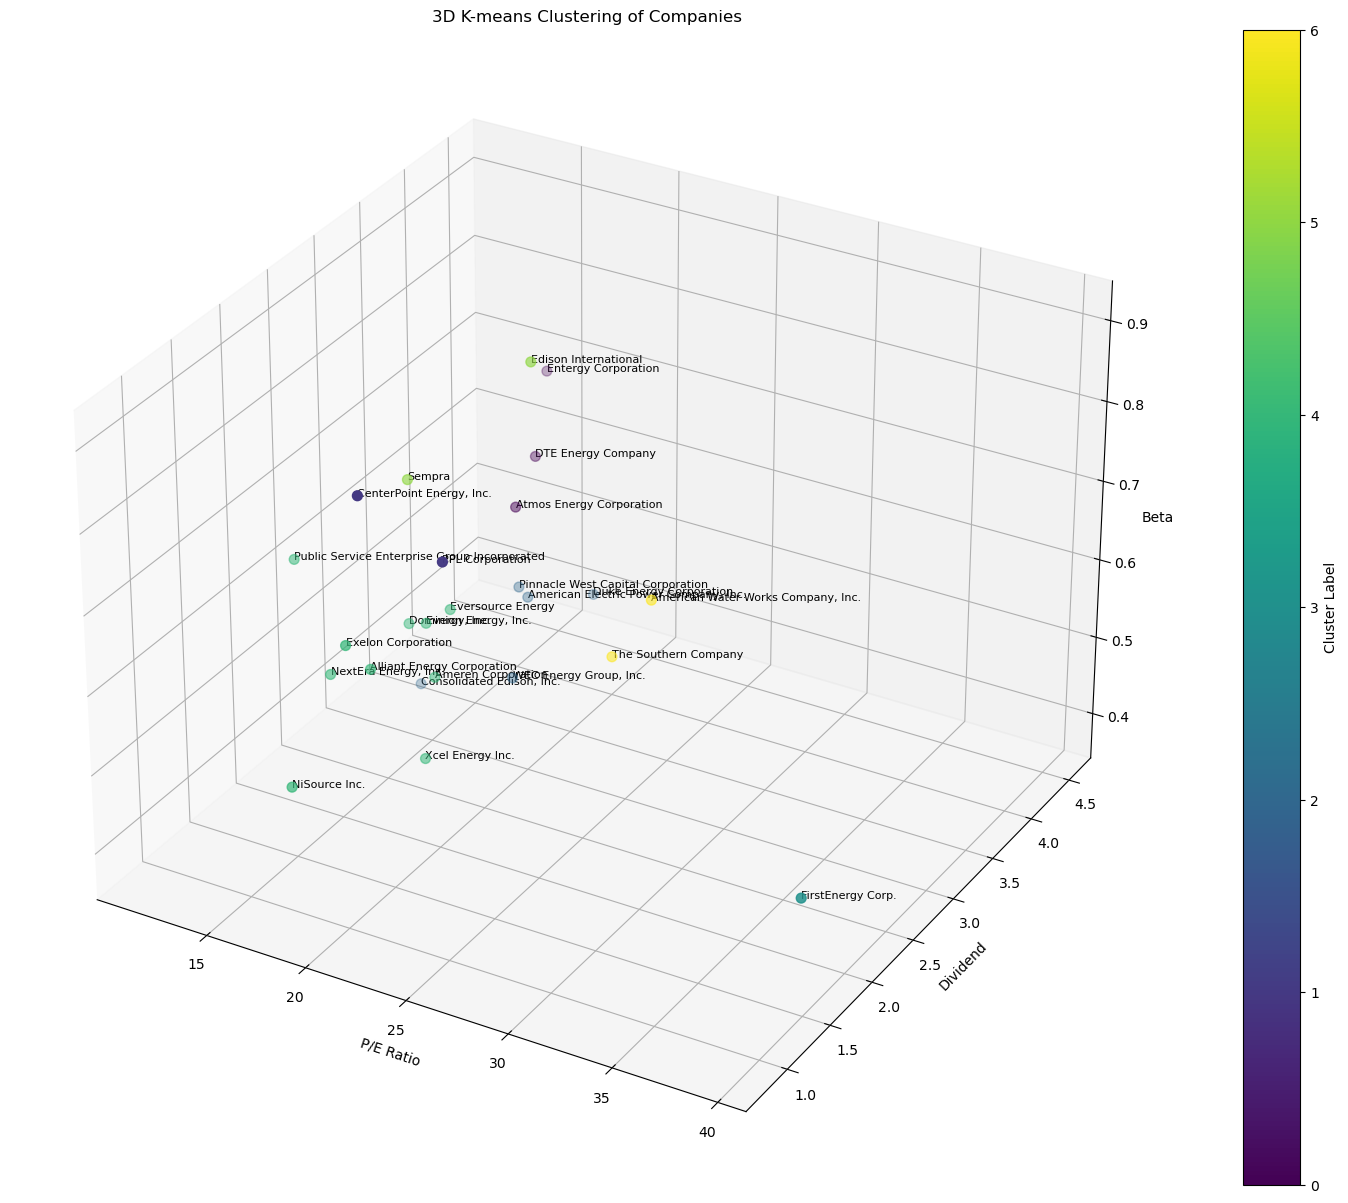

In [3]:
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=0, n_init = 10)
clusters = kmeans.fit_predict(features_scaled)

# Add the cluster information to the DataFrame
df_numeric['Cluster'] = clusters

print(df_numeric.groupby('Cluster').mean(numeric_only = 'True'))

# Assuming df_numeric already contains the 'Cluster' column from K-means
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the three features and coloring by cluster assignment
scatter = ax.scatter(df_numeric['PE Ratio'], 
                     df_numeric['Dividend'], 
                     df_numeric['Beta'], 
                     c=df_numeric['Cluster'], 
                     cmap='viridis',
                    s= 50)

for i, txt in enumerate(df_numeric['CompanyName']):
    ax.text(df_numeric['PE Ratio'].iloc[i], 
            df_numeric['Dividend'].iloc[i], 
            df_numeric['Beta'].iloc[i], 
            '%s' % (txt), size=8, zorder=1)


# Set labels
ax.set_xlabel('P/E Ratio')
ax.set_ylabel('Dividend')
ax.set_zlabel('Beta')

# Title and color bar
plt.title('3D K-means Clustering of Companies')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Cluster Label')

# Show the plot
plt.show()


In [4]:
# Companies that are closer together in the 3D space
# and share the same color are considered to be more similar to 
# each other according to the features used.

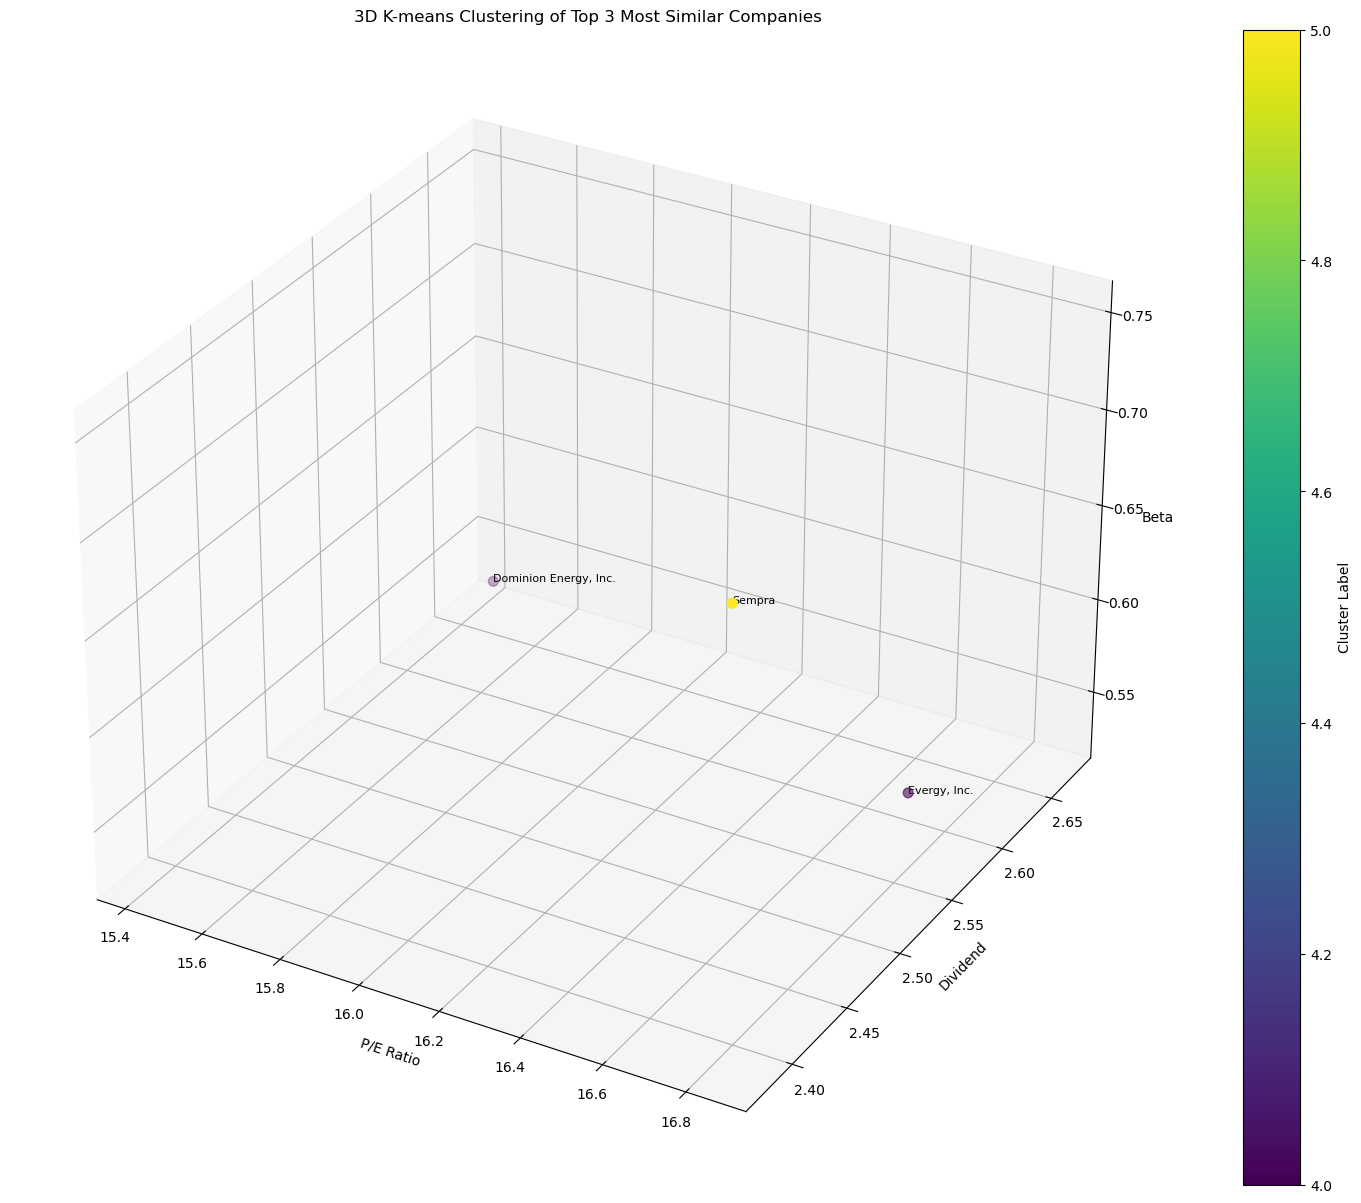

In [5]:
top_3_companies = [most_sim_company_name, second_sim_company_name, third_sim_company_name]

df_top_3 = df_numeric[df_numeric['CompanyName'].isin(top_3_companies)]

# Assuming df_numeric already contains the 'Cluster' column from K-means
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the three features and coloring by cluster assignment
scatter = ax.scatter(df_top_3['PE Ratio'], 
                     df_top_3['Dividend'], 
                     df_top_3['Beta'], 
                     c=df_top_3['Cluster'], 
                     cmap='viridis',
                    s= 50)

for i, txt in enumerate(df_top_3['CompanyName']):
        ax.text(df_top_3['PE Ratio'].iloc[i], 
            df_top_3['Dividend'].iloc[i], 
            df_top_3['Beta'].iloc[i], 
            '%s' % (txt), size=8, zorder=1)

# Set labels
ax.set_xlabel('P/E Ratio')
ax.set_ylabel('Dividend')
ax.set_zlabel('Beta')

# Title and color bar
plt.title('3D K-means Clustering of Top 3 Most Similar Companies')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Cluster Label')

# Show the plot
plt.show()
